## ReadMe

This notebook creates a summary table from a list of files and columns that are the direct output of CCDR analytic tool.

In [1]:
# Importing all the dependencies
import datetime, os, shutil, gc, socket, glob
from tqdm.notebook import tqdm
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Defining the initial parameters
sISO = 'KHM'  # Select here the country code of analysis
sADM = 'ADM3' # Select here the ADM level of analysis
sHaz = ['AP', 'ASI_S1_30perc', 'ASI_S1_50perc', 'CF', 'FL', 'HS', 'LS', 'TC'] # Select here the hazards for summary
sExp_agri    = 'ESA20_agri'
sExp_builtup = 'WSF19'
sExp_pop     = 'WPOP20'

In [5]:
# Retrieving the list of ,gpkg files to process
sFiles = glob.glob('./*.gpkg')
sFiles = [s for s in sFiles if sISO in s]
sFiles = [s for s in sFiles if sADM in s]

# Defining the list of column names and description for the ADM data
iADM = int(sADM[len(sADM)-1])
sADMcols = ['ADM'+str(i)+'_CODE' for i in range(iADM+1)]
sADMcols = sADMcols + ['ADM'+str(i)+'_NAME' for i in range(iADM+1)]
sADMcolsDesc = ['ADM'+str(i)+' unique identifier code' for i in range(iADM+1)]
sADMcolsDesc = sADMcolsDesc + ['ADM'+str(i)+' unit name' for i in range(iADM+1)]

# Defining the list of files to extract info for summary (the item order of sFileGet, sFileGetCols, and sFileGetColsDesc must match)
sFileGet = [
    sISO+'_'+sADM+'_'+'AP_pop_'+sExp_pop+'_class.gpkg', 
    sISO+'_'+sADM+'_'+'ASI_S1_30perc_agri_'+sExp_agri+'_function.gpkg', 
    sISO+'_'+sADM+'_'+'ASI_S1_50perc_agri_'+sExp_agri+'_function.gpkg',
    sISO+'_'+sADM+'_'+'ASI_S2_30perc_agri_'+sExp_agri+'_function.gpkg',
    sISO+'_'+sADM+'_'+'ASI_S2_50perc_agri_'+sExp_agri+'_function.gpkg',
    sISO+'_'+sADM+'_'+'CF_agri_'+sExp_agri+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'CF_builtup_'+sExp_builtup+'_EAE_class.gpkg', 
    sISO+'_'+sADM+'_'+'CF_builtup_'+sExp_builtup+'_EAI_function.gpkg',
    sISO+'_'+sADM+'_'+'CF_pop_'+sExp_pop+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'CF_pop_'+sExp_pop+'_EAI_function.gpkg',
    sISO+'_'+sADM+'_'+'FL_agri_'+sExp_agri+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'FL_builtup_'+sExp_builtup+'_EAE_class.gpkg', 
    sISO+'_'+sADM+'_'+'FL_builtup_'+sExp_builtup+'_EAI_function.gpkg',
    sISO+'_'+sADM+'_'+'FL_pop_'+sExp_pop+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'FL_pop_'+sExp_pop+'_EAI_function.gpkg',
    sISO+'_'+sADM+'_'+'HS_pop_'+sExp_pop+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'EQ_builtup_'+sExp_builtup+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'EQ_pop_'+sExp_pop+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'LS_builtup_'+sExp_builtup+'_class.gpkg',
    sISO+'_'+sADM+'_'+'LS_pop_'+sExp_pop+'_class.gpkg',
    sISO+'_'+sADM+'_'+'TC_agri_'+sExp_agri+'_EAE_class.gpkg',
    sISO+'_'+sADM+'_'+'TC_builtup_'+sExp_builtup+'_EAE_class.gpkg', 
    sISO+'_'+sADM+'_'+'TC_builtup_'+sExp_builtup+'_EAI_function.gpkg',
    sISO+'_'+sADM+'_'+'TC_pop_'+sExp_pop+'_EAE_class.gpkg',
]

# Defining the list of columns (matching in order sFilesGet) to extract info for summary
sFileGetCols = [
    'AP_pop_'+sExp_pop+'_C2',               # AP - Air Pollution - High hazard 15-25 μg/m3 - 16% increased mortality rate
    'DR.S1.30p_agri_'+sExp_agri+'_freq',    # ASI_S1_30perc - Drought
    'DR.S1.50p_agri_'+sExp_agri+'_freq',    # ASI_S1_50perc - Drought
    'DR.S2.30p_agri_'+sExp_agri+'_freq',    # ASI_S2_30perc - Drought
    'DR.S2.50p_agri_'+sExp_agri+'_freq',    # ASI_S2_50perc - Drought
    'CF_agri_'+sExp_agri+'_C0_EAE',         # CF - Coastal Flood - Over 5cm of flood depth
    'CF_builtup_'+sExp_builtup+'_C0_EAE',   # CF - Coastal Flood - Over 5cm of flood depth
    'CF_builtup_'+sExp_builtup+'_EAI',      # CF - Coastal Flood - Impact on builtup area
    'CF_pop_'+sExp_pop+'_C0_EAE',           # CF - Coastal Flood - Over 5cm of flood depth
    'CF_pop_'+sExp_pop+'_EAI',              # CF - Coastal Flood - Impact on population (mortality)
    'FL_agri_'+sExp_agri+'_C0_EAE',         # FL - River Flood - Over 5cm of flood depth
    'FL_builtup_'+sExp_builtup+'_C0_EAE',   # FL - River Flood - Over 5cm of flood depth
    'FL_builtup_'+sExp_builtup+'_EAI',      # FL - River Flood - Impact on builtup area
    'FL_pop_'+sExp_pop+'_C0_EAE',           # FL - River Flood - Over 5cm of flood depth
    'FL_pop_'+sExp_pop+'_EAI',              # FL - River Flood - Impact on population (mortality)
    'HS_pop_'+sExp_pop+'_C0_EAE',           # HS - Heat Stress - Very strong hazard - WBGT (°C) 28-30°
    'EQ_builtup_'+sExp_builtup+'_C0_EAE',   # EQ - Earthquake - Strong perceived shaking - Velocity 9.64-20.00 cm/s - Light potential damage
    'EQ_pop_'+sExp_pop+'_C0_EAE',           # EQ - Earthquake - Strong perceived shaking - Velocity 9.64-20.00 cm/s - Light potential damage
    'LS_builtup_'+sExp_builtup+'_C2',       # LS - Landslide - High hazard - ARUP Wet LS > 0.01
    'LS_pop_'+sExp_pop+'_C2',               # LS - Landslide - High hazard - ARUP Wet LS > 0.01
    'TC_agri_'+sExp_agri+'_C3_EAE',         # TC - Tropical Cyclone - Category 3 Saffir–Simpson scale - Maximum sustained wind speed > 50 m/s
    'TC_builtup_'+sExp_builtup+'_C3_EAE',   # TC - Tropical Cyclone - Category 3 Saffir–Simpson scale - Maximum sustained wind speed > 50 m/s
    'TC_builtup_'+sExp_builtup+'_EAI',      # TC - Tropical Cyclone - Impact on builtup area
    'TC_pop_'+sExp_pop+'_C3_EAE',           # TC - Tropical Cyclone - Category 3 Saffir–Simpson scale - Maximum sustained wind speed > 50 m/s
]


# Defining the description of the list of columns (matching in order sFilesGet) to extract info for summary
sFileGetColsDesc = [
    'Population exposed to high air pollution hazard (population count and relative)',
    'Frequency of severe agricultural drought affecting at least 30% of arable land during growing season 1 (percentage of historical period 1984-2022)',
    'Frequency of severe agricultural drought affecting at least 50% of arable land during growing season 1 (percentage of historical period 1984-2022)',
    'Frequency of severe agricultural drought affecting at least 30% of arable land during growing season 2 (percentage of historical period 1984-2022)',
    'Frequency of severe agricultural drought affecting at least 50% of arable land during growing season 2 (percentage of historical period 1984-2022)',
    'Expected annual exposure of agricultural land to coastal floods (hectares and relative)', 
    'Expected annual exposure of builtup area to coastal floods (hectares and relative)', 
    'Expected annual impact on builtup area due to coastal floods (hectares and relative)', 
    'Expected annual exposure of population to coastal floods (population count and relative)', 
    'Expected annual mortality due to coastal floods (population count and relative)', 
    'Expected annual exposure of agricultural land to river floods (hectares and relative)', 
    'Expected annual exposure of builtup area to river floods (hectares and relative)', 
    'Expected annual impact on builtup area due to river floods (hectares and relative)', 
    'Expected annual exposure of population to river floods (population count and relative)', 
    'Expected annual mortality due to river floods (population count and relative)', 
    'Expected annual exposure of population to very strong heat stress hazard (population count and relative)', 
    'Expected annual exposure of builtup area to strong perceived shaking earthquake hazard (hectares and relative)', 
    'Expected annual exposure of population to strong perceived shaking earthquake hazard (population count and relative)', 
    'Builtup area exposed to high landslide hazard (hectares and relative)',
    'Population exposed to high landslide hazard (population count and relative)',
    'Expected annual exposure of agricultural land to tropical cyclone category 3 on the Saffir–Simpson scale (hectares and relative)', 
    'Expected annual exposure of builtup area to tropical cyclone category 3 on the Saffir–Simpson scale (hectares and relative)', 
    'Expected annual impact on builtup area due to tropical cyclone (hectares and relative)', 
    'Expected annual exposure of population to tropical cyclone category 3 on the Saffir–Simpson scale (hectares and relative)', 
]

# Filtering sHaz in sFileGet
sFileGetFilter = []
for sHazStr in sHaz: sFileGetFilter = sFileGetFilter + [s for s in sFileGet if sHazStr in s]
sFileGetFilterIndex = [i for i, val in enumerate(sFileGet) if val in sFileGetFilter]

# Filtering the list of column names and description based on the filter of files
sFileGetColsFilter = [sFileGetCols[i] for i in sFileGetFilterIndex]
sFileGetColsDescFilter = [sFileGetColsDesc[i] for i in sFileGetFilterIndex]

# Creating the summary description tab as a pandas data.frame
sSummaryDesc = {'Column Name':['Summary']+sADMcols+sFileGetColsFilter, 
                'Description':[' ']+sADMcolsDesc+sFileGetColsDescFilter}
dfSummaryDesc = pd.DataFrame(sSummaryDesc)

# Reading the dummy gpd file to store data into
gpdData = gpd.read_file(sFiles[0])
gpdData = gpdData[['geometry']+sADMcols]

# Adding the agri, builtup, and pop ADM values
sFileAgri = [s for s in sFiles if 'agri' in s][0]
gpdDataAgri = gpd.read_file(sFileAgri)[['geometry']+sADMcols+[sADM+'_agri_'+sExp_agri]]
gpdData = gpdData.merge(gpdDataAgri, how='left', on=['geometry']+sADMcols)
sFileBuiltup = [s for s in sFiles if 'builtup' in s][0]
gpdDataBuiltup = gpd.read_file(sFileBuiltup)[['geometry']+sADMcols+[sADM+'_builtup_'+sExp_builtup]]
gpdData = gpdData.merge(gpdDataBuiltup, how='left', on=['geometry']+sADMcols)
sFilePop = [s for s in sFiles if 'pop' in s][0]
gpdDataPop = gpd.read_file(sFilePop)[['geometry']+sADMcols+[sADM+'_pop_'+sExp_pop]]
gpdData = gpdData.merge(gpdDataPop, how='left', on=['geometry']+sADMcols)
del(sFileAgri,sFileBuiltup,sFilePop,gpdDataAgri,gpdDataBuiltup,gpdDataPop)

# For every file in sFileGetFilter, retrieve the desired columns in sFileGetColsFilter for the original ADM level
for i in range(len(sFileGetFilter)):
    sFileGetFilterOpen = sFileGetFilter[i]
    gpdDataOpen = gpd.read_file(sFileGetFilterOpen)
    sFileGetColsNames = sFileGetColsFilter[i]
    sFileGetColsOpen = sFileGetColsNames.split('_')
    sFileGetColsOpen = sFileGetColsOpen[1:len(sFileGetColsOpen)]
    sFileGetColsOpen = '_'.join(sFileGetColsOpen)
    if sFileGetColsOpen+'%' in gpdDataOpen.columns: 
        sFileGetColsNames = [sFileGetColsNames] + [sFileGetColsNames+'%']
        sFileGetColsOpen = [sFileGetColsOpen] + [sFileGetColsOpen+'%']
    else:
        sFileGetColsNames = [sFileGetColsNames]
        sFileGetColsOpen = [sFileGetColsOpen]
    gpdDataOpen = gpdDataOpen[['geometry']+sADMcols+sFileGetColsOpen]
    gpdDataColNames = list(gpdData.columns) + sFileGetColsNames
    gpdData = gpdData.merge(gpdDataOpen, how='left', on=['geometry']+sADMcols)
    gpdData.columns = gpdDataColNames
dfData = pd.DataFrame(gpdData)
dfData = dfData.drop(columns=['geometry'])

# Creating a single Excel output file with all .csv information
dfOverview = pd.DataFrame(['Overview'])
with pd.ExcelWriter(sISO+'_'+sADM+'_RSK.xlsx') as writer: 
    print('Creating a single Excel output file with all information')
    # Creating the legend overview and summary at ADM level tabs (overview is empty and needs to be manually updated later in Excel)
    dfSummaryDesc.to_excel(writer, sheet_name='Legend')
    dfOverview.to_excel(writer, sheet_name='Overview')
    dfData.to_excel(writer, sheet_name=sADM+'_Summary')
    # Computing the aggregate ADM results, from the original ADM level up to ADM0
    print('Writing the aggregate ADM results, from the original ADM level up to ADM0')
    dfDataAgg = dfData.copy()
    for j in reversed(range(iADM)):
        # Getting the list of ADM codes to aggregate to
        sADMagg = 'ADM'+str(j)
        sADMcolsAgg = ['ADM'+str(i)+'_CODE' for i in range(j+1)]
        sADMcolsAgg = sADMcolsAgg + ['ADM'+str(i)+'_NAME' for i in range(j+1)]
        # Computing the weighted average for drought (DR) related variables
        sColDR = [s for s in list(dfDataAgg.columns) if 'DR.S' in s]
        for iCol in range(len(sColDR)):
            if iCol == 0:
                dfDRtmp = dfDataAgg.groupby(sADMcolsAgg, as_index=False).apply(lambda x: np.average(x[sColDR[iCol]], weights=x['ADM'+str(j+1)+'_agri_'+sExp_agri]))
            else:
                dfDRtmp = dfDRtmp.merge(dfDataAgg.groupby(sADMcolsAgg, as_index=False).apply(lambda x: np.average(x[sColDR[iCol]], 
                                                                                                                  weights=x['ADM'+str(j+1)+'_agri_'+sExp_agri])), 
                                        how='left', on=sADMcolsAgg)
            dfDRtmpColNames = list(dfDRtmp.columns)
            dfDRtmpColNames[len(dfDRtmpColNames)-1] = sColDR[iCol]
            dfDRtmp.columns = dfDRtmpColNames
        # Aggregating the data by sum
        dfDataAgg = dfDataAgg.groupby(sADMcolsAgg, as_index=False).sum()
        dfDataAgg = dfDataAgg.drop(columns=['ADM'+str(j+1)+'_CODE'])
        dfDataAggCols = list(dfDataAgg.columns)
        dfDataAgg.columns = [s.replace('ADM'+str(j+1), sADMagg) for s in dfDataAggCols]
        # Applying the corrected weighted average for drought (DR) related variables
        dfDataAgg = dfDataAgg.drop(columns=sColDR)
        dfDataAgg = dfDataAgg.merge(dfDRtmp, how='left', on=sADMcolsAgg)
        # Computing the relative '%' values
        sColRelative = [s for s in list(dfDataAgg.columns) if '%' in s]
        sColRelative_agri    = [s for s in sColRelative if 'agri' in s]
        sColRelative_builtup = [s for s in sColRelative if 'builtup' in s]
        sColRelative_pop     = [s for s in sColRelative if 'pop' in s]
        for sCol in sColRelative_agri:    dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_agri_'+sExp_agri]].values
        for sCol in sColRelative_builtup: dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_builtup_'+sExp_builtup]].values
        for sCol in sColRelative_pop:     dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_pop_'+sExp_pop]].values
        # Creating the tabs for aggregate ADM levels, up to ADM0
        dfDataAgg.to_excel(writer, sheet_name=sADMagg+'_Summary')
    # Adding the original outputs from the analysis
    print('Adding the original single outputs from the analysis')
    for sFile in tqdm(sFileGetFilter):
        dfCSV = pd.read_csv(sFile.replace('.gpkg','.csv'))
        sSheet = sFile.split('/')
        sSheet = sSheet[len(sSheet)-1]
        sSheet = sSheet.replace('.gpkg','').replace('./'+sISO+'_','').replace(sADM+'_','')[:31]
        dfCSV.to_excel(writer, sheet_name=sSheet)
    # Saving results to disk
    print('Saving results to disk')
    writer.save()
print('Done!')

Creating a single Excel output file with all information
Writing the aggregate ADM results, from the original ADM level up to ADM0
Adding the original single outputs from the analysis


  0%|          | 0/20 [00:00<?, ?it/s]

Saving results to disk
Done!


In [21]:
dfDataAgg = dfData.copy()
j = 2
# Getting the list of ADM codes to aggregate to
sADMagg = 'ADM'+str(j)
sADMcolsAgg = ['ADM'+str(i)+'_CODE' for i in range(j+1)]
sADMcolsAgg = sADMcolsAgg + ['ADM'+str(i)+'_NAME' for i in range(j+1)]
# Computing the weighted average for drought (DR) related variables
sColDR = [s for s in list(dfDataAgg.columns) if 'DR.S' in s]
for iCol in range(len(sColDR)):
    if iCol == 0:
        dfDRtmp = dfDataAgg.groupby(sADMcolsAgg, as_index=False).apply(lambda x: np.average(x[sColDR[iCol]], weights=x['ADM'+str(j+1)+'_agri_'+sExp_agri]))
    else:
        dfDRtmp = dfDRtmp.merge(dfDataAgg.groupby(sADMcolsAgg, as_index=False).apply(lambda x: np.average(x[sColDR[iCol]], 
                                                                                                          weights=x['ADM'+str(j+1)+'_agri_'+sExp_agri])), 
                                how='left', on=sADMcolsAgg)
    dfDRtmpColNames = list(dfDRtmp.columns)
    dfDRtmpColNames[len(dfDRtmpColNames)-1] = sColDR[iCol]
    dfDRtmp.columns = dfDRtmpColNames

In [22]:
dfDRtmp

,ADM0_CODE,ADM1_CODE,ADM2_CODE,ADM0_NAME,ADM1_NAME,ADM2_NAME,DR.S1.30p_agri_ESA20_agri_freq,DR.S1.50p_agri_ESA20_agri_freq
0,KHM,1,102,Cambodia,Banteay Meanchey,Mongkol Borei,0.032333,0.027636
1,KHM,1,103,Cambodia,Banteay Meanchey,Phnum Srok,0.056202,0.028409
2,KHM,1,104,Cambodia,Banteay Meanchey,Preah Netr Preah,0.039900,0.019822
3,KHM,1,105,Cambodia,Banteay Meanchey,Ou Chrov,0.039171,0.072831
4,KHM,1,106,Cambodia,Banteay Meanchey,Serei Saophoan,0.017858,0.009327
...,...,...,...,...,...,...,...,...
197,KHM,25,2503,Cambodia,Tboung Khmum,Ou Reang Ov,0.158689,0.082693
198,KHM,25,2504,Cambodia,Tboung Khmum,Krouch Chhmar,0.179433,0.027261
199,KHM,25,2505,Cambodia,Tboung Khmum,Dambae,0.089113,0.033114
200,KHM,25,2506,Cambodia,Tboung Khmum,Ponhea Kraek,0.081731,0.029529


Index(['ADM0_CODE', 'ADM1_CODE', 'ADM2_CODE', 'ADM0_NAME', 'ADM1_NAME',
       'ADM2_NAME',        None],
      dtype='object')

In [47]:
# Computing the aggregate ADM results, from the original ADM level up to ADM0
for j in range(iADM):
    # Getting the list of ADM codes to aggregate to
    sADMcolsAgg = ['ADM'+str(i)+'_CODE' for i in range(j+1)]
    sADMcolsAgg = sADMcolsAgg + ['ADM'+str(i)+'_NAME' for i in range(j+1)]
    print(sADMcolsAgg)

['ADM0_CODE', 'ADM0_NAME']
['ADM0_CODE', 'ADM1_CODE', 'ADM0_NAME', 'ADM1_NAME']
['ADM0_CODE', 'ADM1_CODE', 'ADM2_CODE', 'ADM0_NAME', 'ADM1_NAME', 'ADM2_NAME']


In [ ]:
# Computing the aggregate ADM results, from the original ADM level up to ADM0
dfDataAgg = dfData.copy()
for j in reversed(range(iADM)):
    # Getting the list of ADM codes to aggregate to
    sADMagg = 'ADM'+str(j)
    sADMcolsAgg = ['ADM'+str(i)+'_CODE' for i in range(j+1)]
    sADMcolsAgg = sADMcolsAgg + ['ADM'+str(i)+'_NAME' for i in range(j+1)]
    # Aggregating the data by sum
    dfDataAgg = dfDataAgg.groupby(sADMcolsAgg, as_index=False).sum()
    dfDataAgg = dfDataAgg.drop(columns=['ADM'+str(j+1)+'_CODE'])
    dfDataAggCols = list(dfDataAgg.columns)
    dfDataAgg.columns = [s.replace('ADM'+str(j+1), sADMagg) for s in dfDataAggCols]
    # Computing the relative '%' values
    sColRelative = [s for s in list(dfDataAgg.columns) if '%' in s]
    sColRelative_agri    = [s for s in sColRelative if 'agri' in s]
    sColRelative_builtup = [s for s in sColRelative if 'builtup' in s]
    sColRelative_pop     = [s for s in sColRelative if 'pop' in s]
    for sCol in sColRelative_agri:    dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_agri_'+sExp_agri]].values
    for sCol in sColRelative_builtup: dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_builtup_'+sExp_builtup]].values
    for sCol in sColRelative_pop:     dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_pop_'+sExp_pop]].values
dfDataAgg

,ADM0_CODE,ADM0_NAME,ADM0_agri_ESA20_agri,ADM0_builtup_WSF19,ADM0_pop_WPOP20,AP_pop_WPOP20_C2,AP_pop_WPOP20_C2%,DR_agri_ESA20_agri_freq,DR_agri_ESA20_agri_freq,CF_agri_ESA20_agri_C0_EAE,...,LS_pop_WPOP20_C2,LS_pop_WPOP20_C2%,TC_agri_ESA20_agri_C3_EAE,TC_agri_ESA20_agri_C3_EAE%,TC_builtup_WSF19_C3_EAE,TC_builtup_WSF19_C3_EAE%,TC_builtup_WSF19_EAI,TC_builtup_WSF19_EAI%,TC_pop_WPOP20_C3_EAE,TC_pop_WPOP20_C3_EAE%
0,KHM,Cambodia,7077219.425,125725.512,1.753075e+07,1.646175e+07,0.939021,162.4957,86.986068,14756.654,...,78677.384,0.004488,0.0,0.0,0.0,0.0,0.192,0.000002,0.0,0.0


In [ ]:
# Creating a single Excel output file with all .csv information
with pd.ExcelWriter(sISO+'_'+sADM+'_RSK.xlsx') as writer: 
    # Creating the legend overview and summary at ADM level tabs (overview is empty and needs to be manually updated later in Excel)
    dfSummaryDesc.to_excel(writer, sheet_name='Legend')
    dfOverview.to_excel(writer, sheet_name='Overview')
    dfData.to_excel(writer, sheet_name=sADM+'_Summary')
    # Computing the aggregate ADM results, from the original ADM level up to ADM0
    dfDataAgg = dfData.copy()
    for j in reversed(range(iADM)):
        # Getting the list of ADM codes to aggregate to
        sADMagg = 'ADM'+str(j)
        sADMcolsAgg = ['ADM'+str(i)+'_CODE' for i in range(j+1)]
        sADMcolsAgg = sADMcolsAgg + ['ADM'+str(i)+'_NAME' for i in range(j+1)]
        # Aggregating the data by sum
        dfDataAgg = dfDataAgg.groupby(sADMcolsAgg, as_index=False).sum()
        dfDataAgg = dfDataAgg.drop(columns=['ADM'+str(j+1)+'_CODE'])
        dfDataAggCols = list(dfDataAgg.columns)
        dfDataAgg.columns = [s.replace('ADM'+str(j+1), sADMagg) for s in dfDataAggCols]
        # Computing the relative '%' values
        sColRelative = [s for s in list(dfDataAgg.columns) if '%' in s]
        sColRelative_agri    = [s for s in sColRelative if 'agri' in s]
        sColRelative_builtup = [s for s in sColRelative if 'builtup' in s]
        sColRelative_pop     = [s for s in sColRelative if 'pop' in s]
        for sCol in sColRelative_agri:    dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_agri_'+sExp_agri]].values
        for sCol in sColRelative_builtup: dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_builtup_'+sExp_builtup]].values
        for sCol in sColRelative_pop:     dfDataAgg[[sCol]] = dfDataAgg[[sCol.replace('%','')]].values/dfDataAgg[[sADMagg+'_pop_'+sExp_pop]].values
        # Creating the tabs for aggregate ADM levels, up to ADM0
        dfDataAgg.to_excel(writer, sheet_name=sADMagg+'_Summary')
    # Adding the original outputs from the analysis
    for sFile in sFileGetFilter:
        dfCSV = pd.read_csv(sFile.replace('.gpkg','.csv'))
        sSheet = sFile.split('/')
        sSheet = sSheet[len(sSheet)-1]
        sSheet = sSheet.replace('.gpkg','').replace('./'+sISO+'_','').replace(sADM+'_','')[:31]
        dfCSV.to_excel(writer, sheet_name=sSheet)

In [5]:
sFileGetFilter

['KHM_ADM3_AP_pop_WPOP20_class.gpkg',
 'KHM_ADM3_ASI_S1_30perc_agri_ESA20_agri_function.gpkg',
 'KHM_ADM3_ASI_S1_50perc_agri_ESA20_agri_function.gpkg',
 'KHM_ADM3_CF_agri_ESA20_agri_EAE_class.gpkg',
 'KHM_ADM3_CF_builtup_WSF19_EAE_class.gpkg',
 'KHM_ADM3_CF_builtup_WSF19_EAI_function.gpkg',
 'KHM_ADM3_CF_pop_WPOP20_EAE_class.gpkg',
 'KHM_ADM3_CF_pop_WPOP20_EAI_function.gpkg',
 'KHM_ADM3_FL_agri_ESA20_agri_EAE_class.gpkg',
 'KHM_ADM3_FL_builtup_WSF19_EAE_class.gpkg',
 'KHM_ADM3_FL_builtup_WSF19_EAI_function.gpkg',
 'KHM_ADM3_FL_pop_WPOP20_EAE_class.gpkg',
 'KHM_ADM3_FL_pop_WPOP20_EAI_function.gpkg',
 'KHM_ADM3_HS_pop_WPOP20_EAE_class.gpkg',
 'KHM_ADM3_LS_builtup_WSF19_class.gpkg',
 'KHM_ADM3_LS_pop_WPOP20_class.gpkg',
 'KHM_ADM3_TC_agri_ESA20_agri_EAE_class.gpkg',
 'KHM_ADM3_TC_builtup_WSF19_EAE_class.gpkg',
 'KHM_ADM3_TC_builtup_WSF19_EAI_function.gpkg',
 'KHM_ADM3_TC_pop_WPOP20_EAE_class.gpkg']

In [3]:
# Creating a single Excel output file with all .csv information
with pd.ExcelWriter(sISO+'_'+sADM+'_RSK.xlsx') as writer:  
    for sFile in sFiles:
        dfCSV = pd.read_csv(sFile.replace('.gpkg','.csv'))
        sSheet = sFile.split('/')
        sSheet = sSheet[len(sSheet)-1]
        sSheet = sSheet.replace('.gpkg','').replace('./'+sISO+'_','').replace(sADM+'_','')[:31]
        dfCSV.to_excel(writer, sheet_name=sSheet)

In [37]:
# Reading the dummy gpd file to store data into
gpdData = gpd.read_file(sFiles[0])
gpdData = gpdData[['ADM0_CODE','ADM1_CODE','ADM2_CODE','ADM3_CODE',
                   'ADM0_NAME','ADM1_NAME','ADM2_NAME','ADM3_NAME','geometry']]
gpdData.isna().sum() # Check for NAs

ADM0_CODE    0
ADM1_CODE    0
ADM2_CODE    0
ADM3_CODE    0
ADM0_NAME    0
ADM1_NAME    0
ADM2_NAME    0
ADM3_NAME    0
geometry     0
dtype: int64

In [42]:
sFiles[0].replace('.gpkg','').replace('./'+sISO+'_','')

'AP_ADM3_pop_WPOP20_class'

In [2]:
# Defining the parameters of DBSCAN
# Common parameters
th_spi = -1.0     # SPI threshold value
c_min  = 200      # Minimum size of a cluster (in cells)
fr_mP  = 0.25     # Fraction value for defining the minimum core points
# For the spatial DBSCAN
s_xy   = 3                                # minimum 1D distance search window (in cells)
mP_xy  = round(2+(fr_mP*((s_xy*s_xy)-2))) # minimum points required in the eps neighborhood for core points
eps_xy = 1.5                              # size (radius) of the epsilon neighbourhood 
# For the temporal DBSCAN
s_t    = 3                                    # minimum distance over the time dimension (in timesteps, e.g. dekad)
mP_t   = round(2+(fr_mP*((s_xy*s_xy*s_t)-2))) # minimum points required in the eps neighborhood for core points
p_xy   = (s_xy-1)/2
p_t    = (s_t-1)/2
eps_t  = math.sqrt(p_xy**2+p_xy**2)+0.00001   # size (radius) of the epsilon neighbourhood 

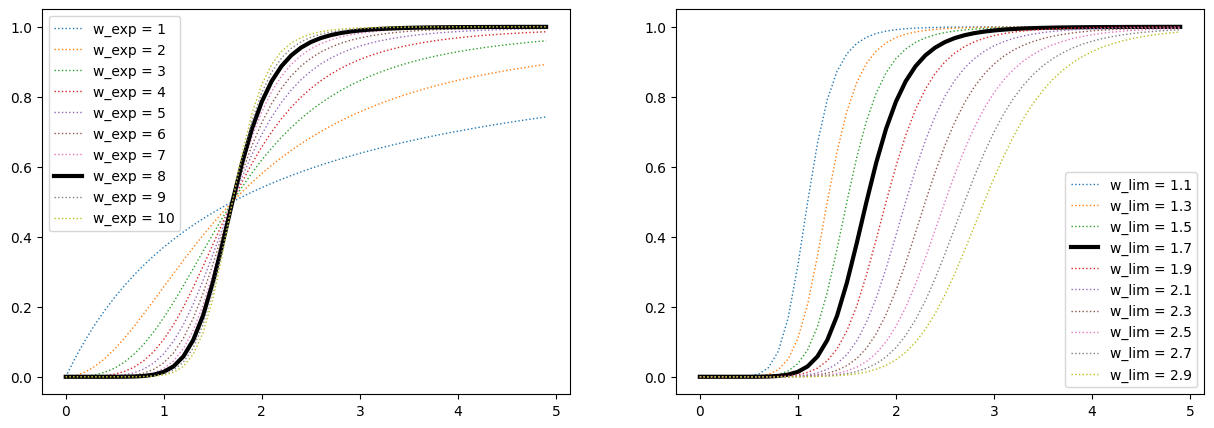

w_exp: 8
w_lim: 1.7


In [3]:
# Defining the weighting function and related parameters
w_exp  = 8        # Parameter that controls the ‘shape’ of the weight function
w_lim  = 1.70     # Parameter that controls the ‘cutoff’ of the weight function
def fweights(spei, w_lim=1.70, w_exp=8):
    return 1-(1/(1+((spei/w_lim)**w_exp)))
    
# Plotting the weight function for visualisation
spei_data  = np.arange(0, 5, 0.1)
w_exp_data = np.arange(1, 11, 1)
w_lim_data = np.arange(1.1, 3.1, 0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for w_exp_plt in w_exp_data:
    if w_exp_plt != 8: ax1.plot(spei_data, fweights(spei_data, 1.70, w_exp_plt), linestyle=':', linewidth=1, label='w_exp = '+str(round(w_exp_plt)))
    if w_exp_plt == 8: ax1.plot(spei_data, fweights(spei_data, 1.70, w_exp_plt), color='black', linestyle='-', linewidth=3, label='w_exp = 8')
ax1.legend()
for w_lim_plt in w_lim_data:
    if w_lim_plt != 1.70: ax2.plot(spei_data, fweights(spei_data, w_lim_plt, 8), linestyle=':', linewidth=1, label='w_lim = '+str(round(w_lim_plt,1)))
    if w_lim_plt == 1.70: ax2.plot(spei_data, fweights(spei_data, w_lim_plt, 8), color='black', linestyle='-', linewidth=3, label='w_lim = 1.7')
ax2.legend()
plt.show()
print('w_exp: '+str(w_exp))
print('w_lim: '+str(w_lim))

In [4]:
# # THIS IS ALL COMMENTED BECAUSE A PRE-PROCESSING HAS ALREADY BEEN RUN USING THIS BLOCK OF CODE TO CREATE THE MASKED SPI NETCDF FILE

# # Reading the SPI-03 and the mask datasets
# spi  = read_era5_xr('SPI-03.nc', centred='atlantic', load=False)
# mask = read_era5_xr('mask_bad_and_desert.nc', centred='atlantic', load=False)

# # Expanding the mask of bad and desert areas over time to match the spi file
# mask = mask*-1 + 1
# mask['mask_bad_and_desert'] = mask['mask_bad_and_desert'].astype('bool')
# mask['mask_bad_and_desert'] = mask['mask_bad_and_desert'].squeeze(dim='time', drop=True)
# mask = mask.drop_dims('time')
# mask = mask.expand_dims(time=spi.time)
# mask = mask.reindex(time=spi.time, method='nearest')

# # Masking out the bad areas
# spi['SPI-03'] = spi['SPI-03'].where(mask['mask_bad_and_desert'])
# del(mask)
# gc.collect()

# # Plotting the results
# proj = ccrs.Robinson(central_longitude=10)
# plot1xr(spi['SPI-03'], 0, cmap=mycmap, vmin=-4.0, vmax=4.0, draw_coastlines=True, cmap_orientation='vertical', 
#         draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
#         proj=proj, height=4, width=7)

# # Saving the file to the disk
# comp = dict(zlib=True, complevel=9)
# encoding = {varnc: comp for varnc in spi.data_vars}
# spi.to_netcdf(str('./SPI-03_masked.nc'), 'w', encoding=encoding)

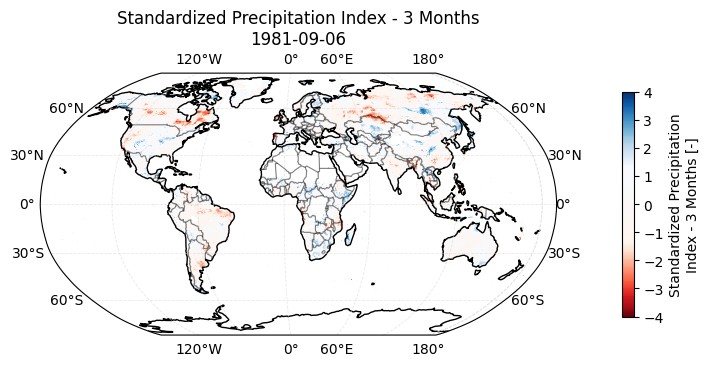

In [5]:
# Reading the SPI-03 and the mask datasets
tbox = ['1981-01-01','2022-12-31']
tbox = ['1981-09-01','1981-10-31']
spi = read_era5_xr('SPI-03_masked.nc', centred='atlantic', load=True, tbox=tbox, chunks_dim='time')

# Plotting the results
plot1xr(spi['SPI-03'], 0, cmap=mycmap, vmin=-4.0, vmax=4.0, draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        proj=proj, height=4, width=7)

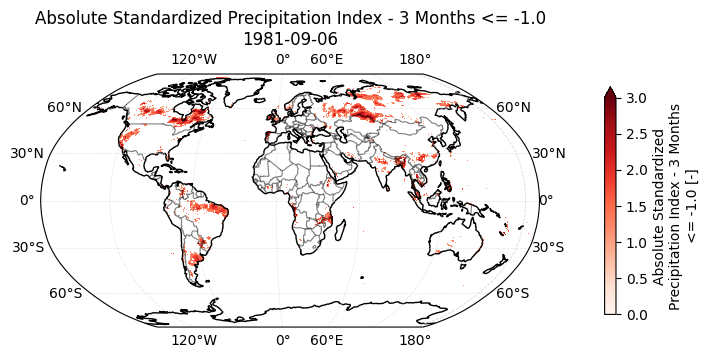

11842

In [6]:
# Defining the sample_weights object
spi_thr = spi['SPI-03'].where(spi['SPI-03'] <= th_spi)*-1
spi_thr.attrs['long_name'] = str('Absolute '+spi_thr.attrs['long_name']+' <= '+str(round(th_spi,1)))

# Plotting the results
plot1xr(spi_thr, 0, cmap='Reds', vmin=0, vmax=3, draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        proj=proj, height=4, width=7)
gc.collect()

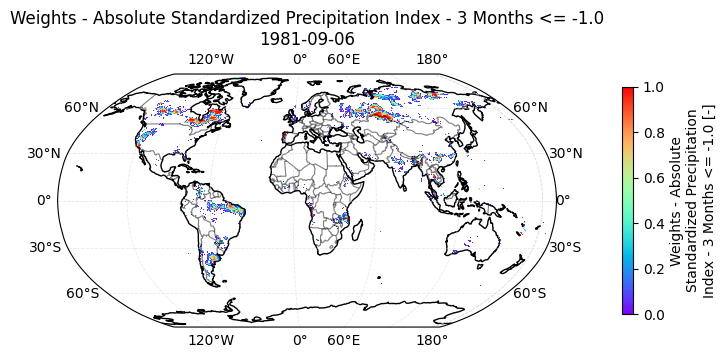

5776

In [7]:
# Defining the sample_weights object
spi_wgt = fweights(spi_thr, w_lim, w_exp)
spi_wgt.attrs['long_name'] = str('Weights - '+spi_wgt.attrs['long_name'])
spi_wgt = spi_wgt.load()

# Plotting the results
plot1xr(spi_wgt, 0, cmap='rainbow', vmin=0, vmax=1, draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        proj=proj, height=4, width=7)
gc.collect()

In [31]:
tmp = spi_wgt.where(spi_wgt>0).to_numpy()
tmp = tmp[23,:,:]
#tmp = tmp[~np.isnan(tmp)]
df = pd.DataFrame(tmp).stack().rename_axis(['y','x']).dropna(how='all').reset_index(name='SPI-03')
df.shape
db = DBSCAN(eps=eps_xy, min_samples=mP_xy, n_jobs=16).fit(df[['y', 'x']], sample_weight=np.squeeze(df[['SPI-03']].values))
labels = db.labels_ 
labels_c_min = np.unique(labels, return_counts=True)
labels_c_min = labels_c_min[0][labels_c_min[1] >= c_min]
labels_c_min = labels_c_min[labels_c_min != -1]
df['cl_t'+str(round(23))] = labels 
df = df[df['cl_t'+str(round(23))].isin(labels_c_min)]

(11158, 4)

  0%|          | 0/6 [00:00<?, ?it/s]

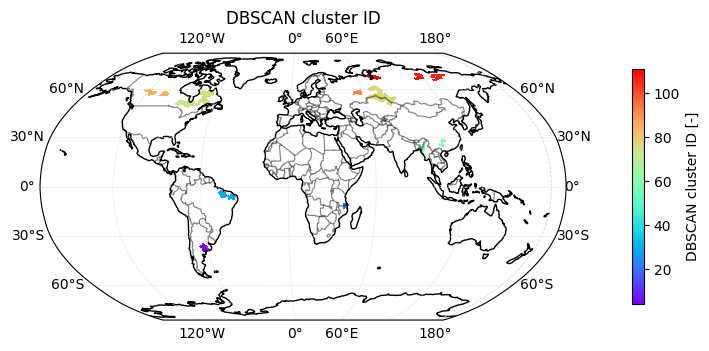

In [8]:
# Initiating the routine to compute the spatial DBSCAN over time
# Creating a dummy template dataframe object to store the results
dfTemplate = spi_wgt.isel(time=0,drop=True).to_dataframe().reset_index()
dfTemplate[['y']] = np.expand_dims(pd.Series(pd.factorize(dfTemplate['lat'])[0], dfTemplate['lat'].index).values, axis=1)
dfTemplate[['x']] = np.expand_dims(pd.Series(pd.factorize(dfTemplate['lon'])[0], dfTemplate['lon'].index).values, axis=1)
dfTemplate = dfTemplate[['y', 'x', 'lat', 'lon']]
# Creating the object spi_cl to store the spatial_clusters results
spi_cl = xr.DataArray(name='dbscan_cl', data=np.nan, dims=spi_wgt.dims, 
                      coords=spi_wgt.coords, 
                      attrs=dict(units='-', long_name = 'DBSCAN cluster ID'))
# Creating the object spi_cl_c_min_mask to store the spatial_clusters mask c_min results
spi_cl_c_min_mask = xr.DataArray(name='dbscan_cl_c_min', data=False, dims=spi_wgt.dims, 
                                 coords=spi_wgt.coords, 
                                 attrs=dict(units='-', long_name = 'DBSCAN cluster over c_min mask'))

# For every time step, compute the spatial DBSCAN
for i in tqdm(range(len(spi_wgt.time))):
    # Computing the spatial DBSCAN
    df = spi_wgt.isel(time=i,drop=True).to_dataframe().reset_index()                                                           # Extracting the weights of all coordinates
    df = pd.merge(df, dfTemplate, on=['lat', 'lon'], how='left')                                                               # Adding the position coordinates
    df = df[['y','x','SPI-03']].dropna(how='any')                                                                              # Extracting the positions and weights for weight != NaN
    db = DBSCAN(eps=eps_xy, min_samples=mP_xy, n_jobs=16).fit(df[['y', 'x']], sample_weight=np.squeeze(df[['SPI-03']].values)) # Computing the spatial DBSCAN
    labels = db.labels_                                                                                                        # Getting the cluster labels
    labels_c_min = np.unique(labels, return_counts=True)                                                                       # Computing the cell count per cluster
    labels_c_min = labels_c_min[0][labels_c_min[1] >= c_min]                                                                   # Kepping clusters pver c_min
    labels_c_min = labels_c_min[labels_c_min != -1]                                                                            # Removing noise clusters
    df = df[['y', 'x']]                                                                                                        # Keeping just the positions in df
    df['cl_t'+str(round(i))] = labels                                                                                          # Merging the label results into df
    df = df[df['cl_t'+str(round(i))].isin(labels_c_min)]                                                                       # Keeping only relevant clusters (c_min)
    dfRes = pd.merge(dfTemplate, df, on=['y', 'x'], how='left')                                                                # Merging the results to dfRes
    dfRes = dfRes[['lat', 'lon', 'cl_t'+str(round(i))]]                                                                        # Keeping the coordinates plus results in dfRes
    dfRes = dfRes.set_index(['lat', 'lon']).to_xarray()                                                                        # Converting the results df to a dataarray object
    spi_cl.loc[dict(time=spi_cl.time[i].values)] = dfRes['cl_t'+str(round(i))].values                                          # Updating the timestep values
    spi_cl_c_min_mask.loc[dict(time=spi_cl_c_min_mask.time[i].values)] = spi_cl.isel(time=i).notnull()                         # Computing the filtered c_min mask

# Cleaning-up
del(df, db, labels, labels_c_min, dfRes)
gc.collect()

# Plotting the results
plot1xr(spi_cl.isel(time=0), cmap='rainbow', draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        proj=proj, height=4, width=7)
gc.collect()

# Saving the file to the disk
spi_cl = spi_cl.to_dataset(promote_attrs=True)
comp = dict(zlib=True, complevel=9)
encoding = {varnc: comp for varnc in spi_cl.data_vars}
spi_cl.to_netcdf(str('./SPI-03_masked_spatialClusters.nc'), 'w', encoding=encoding)

In [9]:
# Clearing old data
del(spi, spi_thr)
gc.collect()

10

In [10]:
# Reading the spi_cl file from file
spi_cl = read_era5_xr('SPI-03_masked_spatialClusters.nc', centred='atlantic', load=True)

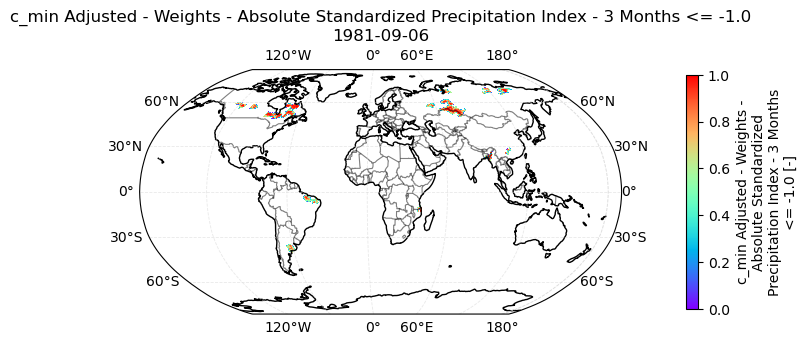

5274

In [11]:
# Updating the sample_weights object with the new c_min threshold
spi_wgt_c_min = spi_wgt.where(spi_cl_c_min_mask)
spi_wgt_c_min.attrs['long_name'] = str('c_min Adjusted - '+spi_wgt.attrs['long_name'])
del(spi_wgt, spi_cl, spi_cl_c_min_mask)
gc.collect()
spi_wgt_c_min = spi_wgt_c_min.load()

# Plotting the results
plot1xr(spi_wgt_c_min, 23, cmap='rainbow', vmin=0, vmax=1, draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        proj=proj, height=4, width=7)
gc.collect()

  0%|          | 0/30 [00:00<?, ?it/s]

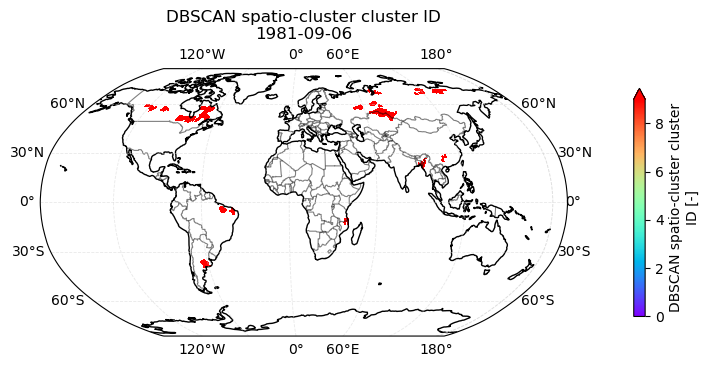

In [12]:
# Initiating the routine to compute the spatial-temporal DBSCAN
# Creating a dummy template dataframe object to store the results
dfTemplate = spi_wgt_c_min.isel(time=0,drop=True).to_dataframe().reset_index()[['lat', 'lon']]
dfTemplate[['y']] = np.expand_dims(pd.Series(pd.factorize(dfTemplate['lat'])[0], dfTemplate['lat'].index).values, axis=1)
dfTemplate[['x']] = np.expand_dims(pd.Series(pd.factorize(dfTemplate['lon'])[0], dfTemplate['lon'].index).values, axis=1)
dfTemplate = dfTemplate[['y', 'x', 'lat', 'lon']]
# Creating the object spi_cl to store the spatial-temporal_clusters results
spi_cl_t = xr.DataArray(name='dbscan_cl_t', data=np.nan, dims=spi_wgt_c_min.dims, 
                        coords=spi_wgt_c_min.coords, 
                        attrs=dict(units='-', long_name = 'DBSCAN spatio-cluster cluster ID'))

# Computing the spatial-temporal DBSCAN
df = spi_wgt_c_min.to_dataframe().reset_index()                                                                                     # Extracting the weights and all coordinates
df = pd.merge(df, dfTemplate, on=['lat', 'lon'], how='left')                                                                        # Adding the position coordinates
df[['time_id']] = np.expand_dims(pd.Series(pd.factorize(df['time'])[0] + 1, df['time'].index).values, axis=1)                       # Creating the temporary time_id column
df = df.dropna(how='any')                                                                                                           # Dropping missing NaN data
db = DBSCAN(eps=eps_t, min_samples=mP_t, n_jobs=16).fit(df[['time_id', 'y', 'x']], sample_weight=np.squeeze(df[['SPI-03']].values)) # Computing the spatial-temporal DBSCAN
labels = db.labels_                                                                                                                 # Getting the cluster labels
df['cl_t'] = labels                                                                                                                 # Merging the results to df
df.replace(-1, np.nan, inplace=True)                                                                                                # Removing the points where no cluster
for i in tqdm(np.unique(df[['time_id']])):                                                                                          # For every time_id, do:
    df_t = df.loc[df['time_id'] == i]                                                                                               # Filtering for the time_id == i
    df_t = df_t[['y', 'x', 'cl_t']]                                                                                                 # Keeping just the coordinates in df
    dfRes = pd.merge(dfTemplate, df_t, on=['y', 'x'], how='left')                                                                   # Merging the results to dfRes
    dfRes = dfRes[['lat', 'lon', 'cl_t']]                                                                                           # Keeping the coordinates plus results in dfRes
    dfRes = dfRes.set_index(['lat', 'lon']).to_xarray()                                                                             # Converting the results df to a dataarray object
    spi_cl_t.loc[dict(time=spi_cl_t.time[i-1].values)] = dfRes['cl_t'].values 
spi_cl_t = spi_cl_t.to_dataset(promote_attrs=True)

# Cleaning-up
del(df, db, labels, df_t, dfRes)
gc.collect()

# Plotting the results
plot1xr(spi_cl_t['dbscan_cl_t'], 23, cmap='rainbow', vmin=0, vmax=9, draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        proj=proj, height=4, width=7)
gc.collect()

# Saving the file to the disk
comp = dict(zlib=True, complevel=9)
encoding = {varnc: comp for varnc in spi_cl_t.data_vars}
spi_cl_t.to_netcdf(str('./SPI-03_masked_spatial-temporalClusters.nc'), 'w', encoding=encoding)

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating the animation over the time dimension...


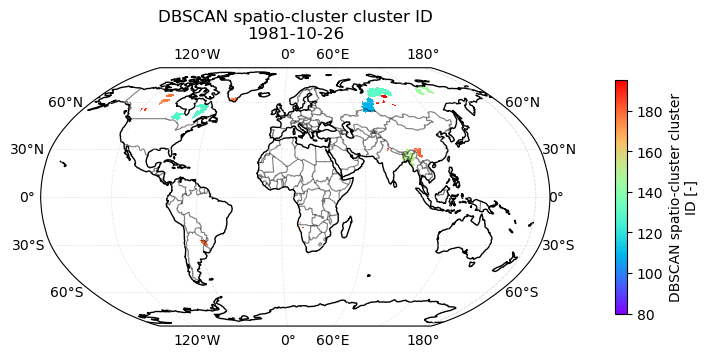

33561

In [13]:
# Plotting the results
tbox = ['1981-09-01','1981-10-31']
spi_cl_t = read_era5_xr('SPI-03_masked_spatial-temporalClusters.nc', centred='atlantic', load=False, tbox=tbox, chunks_dim='time')
plot1xr(spi_cl_t['dbscan_cl_t'], 0, cmap='rainbow', draw_coastlines=True, cmap_orientation='vertical', 
        draw_country_borders=True, draw_gridlines=True, draw_gridlines_labels=True, draw_background_map=False, 
        animated=True, animation_interval=1024,
        proj=proj, height=4, width=7)
gc.collect()